# Präsenzversuch zum Laval-Rotor

Name:  Junghyun Seo   
Datum:  08.02.2024   
Gruppe: 25

## Forschungsfrage

Das Experiment wird mit verschiedenen Anzahlen von Scheiben, unterschiedlichen Durchmessern und Gewichten, usw durchgeführt. Welche Bedingungen würden einen dominanten Einfluss auf die Ergebnisse des Experiments haben?

## Erster Versuch: Prüfstand #X
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

![Prüfstand Lavalrotor](lavalrotor.jpg)

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:
Nur eine Scheibe wurde für das Experiment implementiert, und ihre Masse betrug 960 g. Dicke und Durchmesser betrugen 15mm bzw. 99mm. Als die Maschine gestartet wurde, wurde die Rotation immer schneller, bis es schien, als ob sie stehen geblieben wäre und weniger Geräusche machte.

### Versuchsauswertung

In [77]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [78]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240115_140945_lavalrotor_25_03"
)  # path to the folder with H5-file and metadata
filename = 'data_20240115_140945_lavalrotor_25_03.h5'  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [79]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240115_140945_lavalrotor_25_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240115_140945_lavalrotor_25_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240115_140945_lavalrotor_25_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240115_140945_lavalrotor_25_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [80]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [81]:

# Define the file path
file_path = 'measurement_data/data_20240115_140945_lavalrotor_25_03/data_20240115_140945_lavalrotor_25_03.h5'


def find_dataset_path(hdf5_group, target_dataset):
    for key in hdf5_group.keys():
       
        if isinstance(hdf5_group[key], h5py.Group):
            path_in_group = find_dataset_path(hdf5_group[key], target_dataset)
            if path_in_group:
                return key + '/' + path_in_group
     
        elif key == target_dataset:
            return key

all_accel_x=[]
all_accel_y=[]
all_accel_z=[]
all_timestamp=[]


with h5py.File(file_path, 'r') as hdf5_file:
    

    sorted_keys = sorted(map(int, hdf5_file.keys()))
    rpmlist = set()
   
    for key in sorted_keys:
        print(f"\nKey: {key}")
        
       
        group = hdf5_file[str(key)]
        
     
        target_datasets = ['timestamp', 'acceleration_x', 'acceleration_y', 'acceleration_z','motor_rpm']
        
     
        dataset_paths = {dataset: find_dataset_path(group, dataset) for dataset in target_datasets}
        
    
        if all(dataset_paths.values()):
   
            timestamp_data = np.array(group[dataset_paths['timestamp']])
            accel_x_data = np.array(group[dataset_paths['acceleration_x']])
            accel_y_data = np.array(group[dataset_paths['acceleration_y']])
            accel_z_data = np.array(group[dataset_paths['acceleration_z']])
            motor_rpm_data = np.array(group[dataset_paths['motor_rpm']])
            
            if motor_rpm_data.size == 1:
                rpmlist.add(motor_rpm_data.item()) 
            else:
                rpmlist.update(set(motor_rpm_data.tolist()))  
            
            all_accel_x.append(accel_x_data.tolist())
            all_accel_y.append(accel_y_data.tolist())
            all_accel_z.append(accel_z_data.tolist())
            all_timestamp.append(timestamp_data.tolist())
        
        
            print(f"Timestamp: {timestamp_data}")
            print(f"Acceleration X: {accel_x_data}")
            print(f"Acceleration Y: {accel_y_data}")
            print(f"Acceleration Z: {accel_z_data}")
            print(f"Motor RPM: {motor_rpm_data}")
        else:
            print("Some datasets not found in the specified path.")

            
print("rpmlist", sorted(rpmlist))



Key: 0
Timestamp: [1.89542770e-03 6.67285919e-03 1.09014511e-02 ... 9.99441957e+00
 9.99751091e+00 1.00006199e+01]
Acceleration X: [0.8629852 0.6276256 0.5491724 ... 0.7060788 0.6668522 0.9414384]
Acceleration Y: [0.784532  0.588399  0.4707192 ... 0.6668522 0.784532  0.7453054]
Acceleration Z: [12.160246  12.0425662 12.2386992 ... 12.160246  12.1210194 12.0817928]
Motor RPM: 143

Key: 1
Timestamp: [2.34651566e-03 7.43579865e-03 1.25803947e-02 ... 9.99034715e+00
 9.99365711e+00 9.99776673e+00]
Acceleration X: [0.392266  0.784532  1.569064  ... 0.8237586 0.784532  0.7060788]
Acceleration Y: [0.784532  0.5099458 0.6668522 ... 0.5099458 0.6668522 0.7453054]
Acceleration Z: [12.1994726 12.1210194 12.1210194 ... 11.964113  12.1210194 12.2386992]
Motor RPM: 294

Key: 2
Timestamp: [2.44760513e-03 8.75163078e-03 1.41506195e-02 ... 9.99265480e+00
 9.99567008e+00 9.99877048e+00]
Acceleration X: [0.6668522 0.1176798 1.4121576 ... 0.9022118 0.2353596 0.5099458]
Acceleration Y: [0.4707192 0.392266 

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [82]:
importlib.reload(m_postprocessing)  # reload functions

with h5py.File(file_path, 'r') as hdf5_file:

    sorted_keys = sorted(map(int, hdf5_file.keys()))
    all_accel_magnitudes = []


    for key in sorted_keys:
        group = hdf5_file[str(key)]

        try:
 
            raw_data_group = group['RawData']


            accel_x_data = np.array(raw_data_group[uuid_acceleration]['acceleration_x'])
            accel_y_data = np.array(raw_data_group[uuid_acceleration]['acceleration_y'])
            accel_z_data = np.array(raw_data_group[uuid_acceleration]['acceleration_z'])

 
            accel_magnitude = m_postprocessing.get_vec_accel(accel_x_data, accel_y_data, accel_z_data)

 
            all_accel_magnitudes.append(accel_magnitude)
        except KeyError as e:
            print(f"Error accessing group {key}: {e}")
            
all_interpolated_values = []

for i, accel_magnitude in enumerate(all_accel_magnitudes):
   
    time_data = timestamp_data
    target_size = np.size(accel_magnitude)


  
    interpolated_time_data = m_postprocessing.interpolation(np.arange(len(time_data)), time_data, np.arange(target_size))


    try:
        interpolated_values = m_postprocessing.interpolation(interpolated_time_data, accel_magnitude, interpolation_points)
        all_interpolated_values.append(interpolated_values)

    except Exception as e:
        print(f"Error during interpolation for Group {i + 1}: {e}")

        
all_fft_amplitudes = []
all_fft_frequencies = []

for i, interpolated_values in enumerate(all_interpolated_values):
  
    fft_amplitudes, fft_frequencies = m_postprocessing.my_fft_scaled(interpolated_values, interpolation_points)

  
    all_fft_amplitudes.append(fft_amplitudes)
    all_fft_frequencies.append(fft_frequencies)




#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

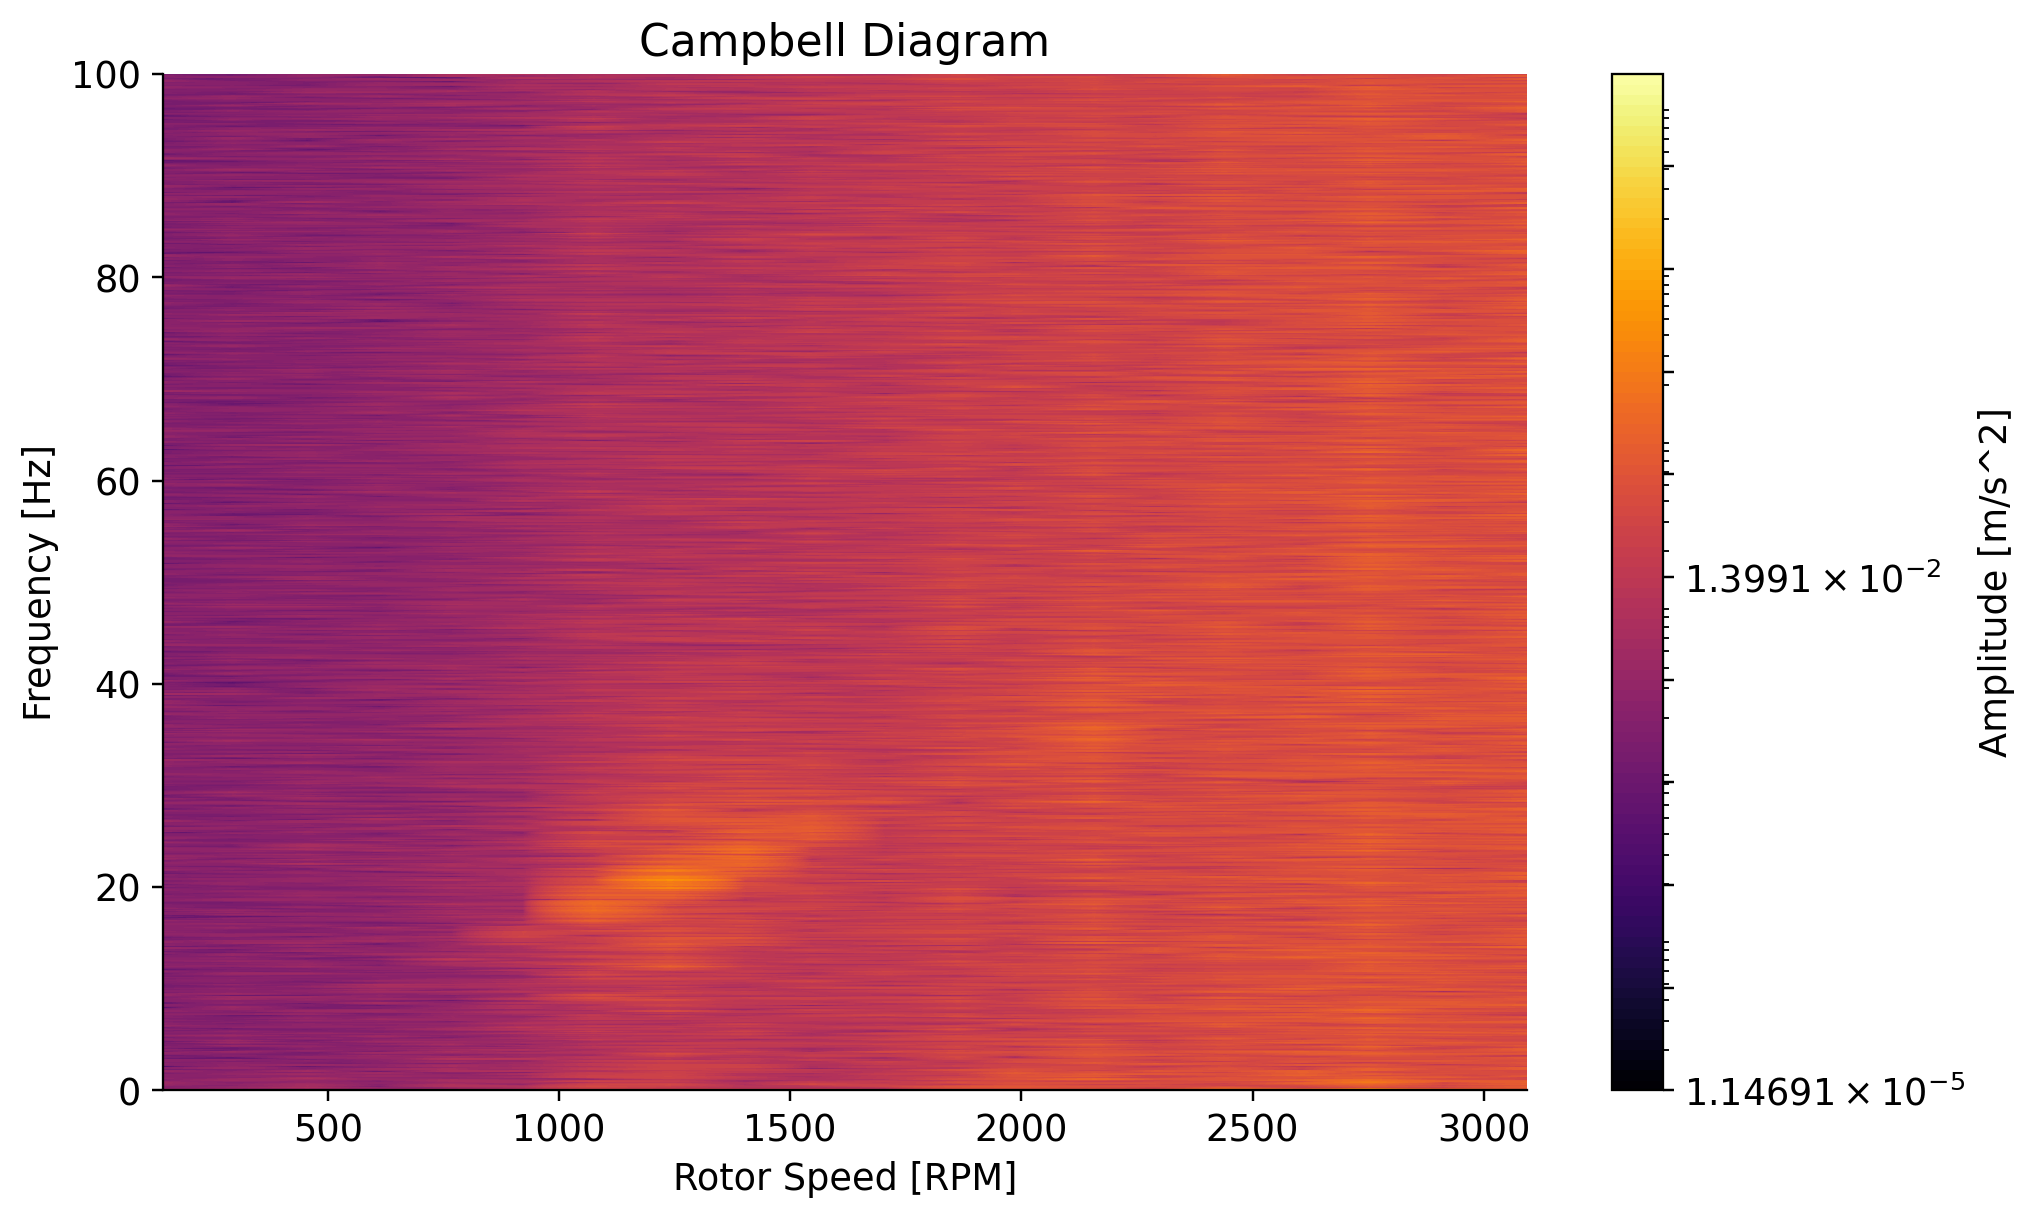

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm 
with h5py.File(file_path, 'r') as f:
    rpm_list = []
    for i in range(len(f.keys())):
        rpm_list.append(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"][()])


fig, ax = plt.subplots(figsize=(10, 6))

x, y = np.meshgrid(rpm_list, fft_frequencies)
z = np.transpose(all_fft_amplitudes)


contour_levels = np.logspace(np.log10(np.min(z)), np.log10(np.max(z)), 100)


contourf = ax.contourf(x, y, z, cmap='inferno', levels=contour_levels, norm=LogNorm())

ax.set_xlabel('Rotor Speed [RPM]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title('Campbell Diagram')
ax.set_ylim(0, 100)

cbar = plt.colorbar(contourf, ax=ax, orientation='vertical')
cbar.set_label('Amplitude [m/s^2]')

plt.show()

## Zweiter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [84]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = 'data_20240102_100928_lavalrotor_01_02.h5'  # name of the H5-file



measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)



# Define the file path
file_path = 'measurement_data/data_20240102_100928_lavalrotor_01_02/data_20240102_100928_lavalrotor_01_02.h5'


def find_dataset_path(hdf5_group, target_dataset):
    for key in hdf5_group.keys():
       
        if isinstance(hdf5_group[key], h5py.Group):
            path_in_group = find_dataset_path(hdf5_group[key], target_dataset)
            if path_in_group:
                return key + '/' + path_in_group
     
        elif key == target_dataset:
            return key

all_accel_x=[]
all_accel_y=[]
all_accel_z=[]
all_timestamp=[]


with h5py.File(file_path, 'r') as hdf5_file:
    

    sorted_keys = sorted(map(int, hdf5_file.keys()))
    rpmlist = set()
   
    for key in sorted_keys:
        print(f"\nKey: {key}")
        
       
        group = hdf5_file[str(key)]
        
     
        target_datasets = ['timestamp', 'acceleration_x', 'acceleration_y', 'acceleration_z','motor_rpm']
        
     
        dataset_paths = {dataset: find_dataset_path(group, dataset) for dataset in target_datasets}
        
    
        if all(dataset_paths.values()):
   
            timestamp_data = np.array(group[dataset_paths['timestamp']])
            accel_x_data = np.array(group[dataset_paths['acceleration_x']])
            accel_y_data = np.array(group[dataset_paths['acceleration_y']])
            accel_z_data = np.array(group[dataset_paths['acceleration_z']])
            motor_rpm_data = np.array(group[dataset_paths['motor_rpm']])
            
            if motor_rpm_data.size == 1:
                rpmlist.add(motor_rpm_data.item()) 
            else:
                rpmlist.update(set(motor_rpm_data.tolist()))  
            
            all_accel_x.append(accel_x_data.tolist())
            all_accel_y.append(accel_y_data.tolist())
            all_accel_z.append(accel_z_data.tolist())
            all_timestamp.append(timestamp_data.tolist())
        
        
            print(f"Timestamp: {timestamp_data}")
            print(f"Acceleration X: {accel_x_data}")
            print(f"Acceleration Y: {accel_y_data}")
            print(f"Acceleration Z: {accel_z_data}")
            print(f"Motor RPM: {motor_rpm_data}")
        else:
            print("Some datasets not found in the specified path.")

            
print("rpmlist", sorted(rpmlist))


Key: 0
Timestamp: [1.99460983e-03 6.97445869e-03 1.14507675e-02 ... 9.99340367e+00
 9.99641156e+00 9.99937415e+00]
Acceleration X: [-0.1176798  0.1569064  0.1569064 ...  0.1176798  0.1176798  0.1176798]
Acceleration Y: [-0.0392266 -0.2353596 -0.1569064 ... -0.0392266 -0.2353596 -0.196133 ]
Acceleration Z: [10.5127288 10.4735022 10.4342756 ... 10.4342756 10.4342756 10.5519554]
Motor RPM: 54

Key: 1
Timestamp: [2.36868858e-03 8.46862793e-03 1.41203403e-02 ... 9.99312305e+00
 9.99628735e+00 9.99953294e+00]
Acceleration X: [0.1176798 0.1176798 0.0392266 ... 0.1176798 0.0784532 0.1176798]
Acceleration Y: [-0.196133  -0.2745862 -0.0392266 ... -0.0784532 -0.1176798 -0.2353596]
Acceleration Z: [10.5519554 10.395049  10.3558224 ... 10.4342756 10.3165958 10.3558224]
Motor RPM: 134

Key: 2
Timestamp: [1.08337402e-03 3.99208069e-03 6.65378571e-03 ... 9.99106550e+00
 9.99485111e+00 9.99878526e+00]
Acceleration X: [0.2353596 0.196133  0.3138128 ... 0.0784532 0.0392266 0.5491724]
Acceleration Y: [-0

Timestamp: [2.11453438e-03 6.54315948e-03 1.07982159e-02 ... 9.99174142e+00
 9.99508762e+00 9.99946475e+00]
Acceleration X: [ 2.0397832  2.8635418 -1.176798  ...  7.4138274 -1.2944778  1.9221034]
Acceleration Y: [-0.6668522 -1.4121576 -1.569064  ...  0.1569064 -0.8629852  0.2745862]
Acceleration Z: [11.375714   9.3359308  9.8851032 ...  9.4536106  9.9243298 11.0226746]
Motor RPM: 1639

Key: 22
Timestamp: [1.13439560e-03 3.98397446e-03 6.61945343e-03 ... 9.99464631e+00
 9.99768877e+00 1.00007186e+01]
Acceleration X: [ 3.530394  -1.3337044  2.8635418 ... -4.903325   1.6867438 -2.1182364]
Acceleration Y: [-2.0790098 -1.765197  -3.4127142 ... -5.3348176  0.5099458 -1.176798 ]
Acceleration Z: [10.591182   8.7475318  9.1790244 ... 10.3165958 10.1596894  9.8851032]
Motor RPM: 1724

Key: 23
Timestamp: [2.36177444e-03 7.43365288e-03 1.26585960e-02 ... 9.99338412e+00
 9.99625516e+00 9.99955535e+00]
Acceleration X: [-1.372931  -1.6867438  1.7259704 ...  2.4320492 -8.041453  -3.334261 ]
Accelerati

#### 2. Verarbeitung der Messdaten

In [85]:
importlib.reload(m_postprocessing)  # reload functions

with h5py.File(file_path, 'r') as hdf5_file:

    sorted_keys = sorted(map(int, hdf5_file.keys()))
    all_accel_magnitudes = []


    for key in sorted_keys:
        group = hdf5_file[str(key)]

        try:
   
            raw_data_group = group['RawData']

 
            accel_x_data = np.array(raw_data_group['1ee823d3-8511-6a0b-8cd5-972f083673c9']['acceleration_x'])
            accel_y_data = np.array(raw_data_group['1ee823d3-8511-6a0b-8cd5-972f083673c9']['acceleration_y'])
            accel_z_data = np.array(raw_data_group['1ee823d3-8511-6a0b-8cd5-972f083673c9']['acceleration_z'])

      
            accel_magnitude = m_postprocessing.get_vec_accel(accel_x_data, accel_y_data, accel_z_data)

 
            all_accel_magnitudes.append(accel_magnitude)
        except KeyError as e:
            print(f"Error accessing group {key}: {e}")
            
all_interpolated_values = []

for i, accel_magnitude in enumerate(all_accel_magnitudes):
 
    time_data = timestamp_data
    target_size = np.size(accel_magnitude)


  
    interpolated_time_data = m_postprocessing.interpolation(np.arange(len(time_data)), time_data, np.arange(target_size))


    try:
        interpolated_values = m_postprocessing.interpolation(interpolated_time_data, accel_magnitude, interpolation_points)
        all_interpolated_values.append(interpolated_values)

    except Exception as e:
        print(f"Error during interpolation for Group {i + 1}: {e}")

        
all_fft_amplitudes = []
all_fft_frequencies = []

for i, interpolated_values in enumerate(all_interpolated_values):

    fft_amplitudes, fft_frequencies = m_postprocessing.my_fft_scaled(interpolated_values, interpolation_points)

 
    all_fft_amplitudes.append(fft_amplitudes)
    all_fft_frequencies.append(fft_frequencies)




#### 3. Darstellung mittels Campbell-Diagramm

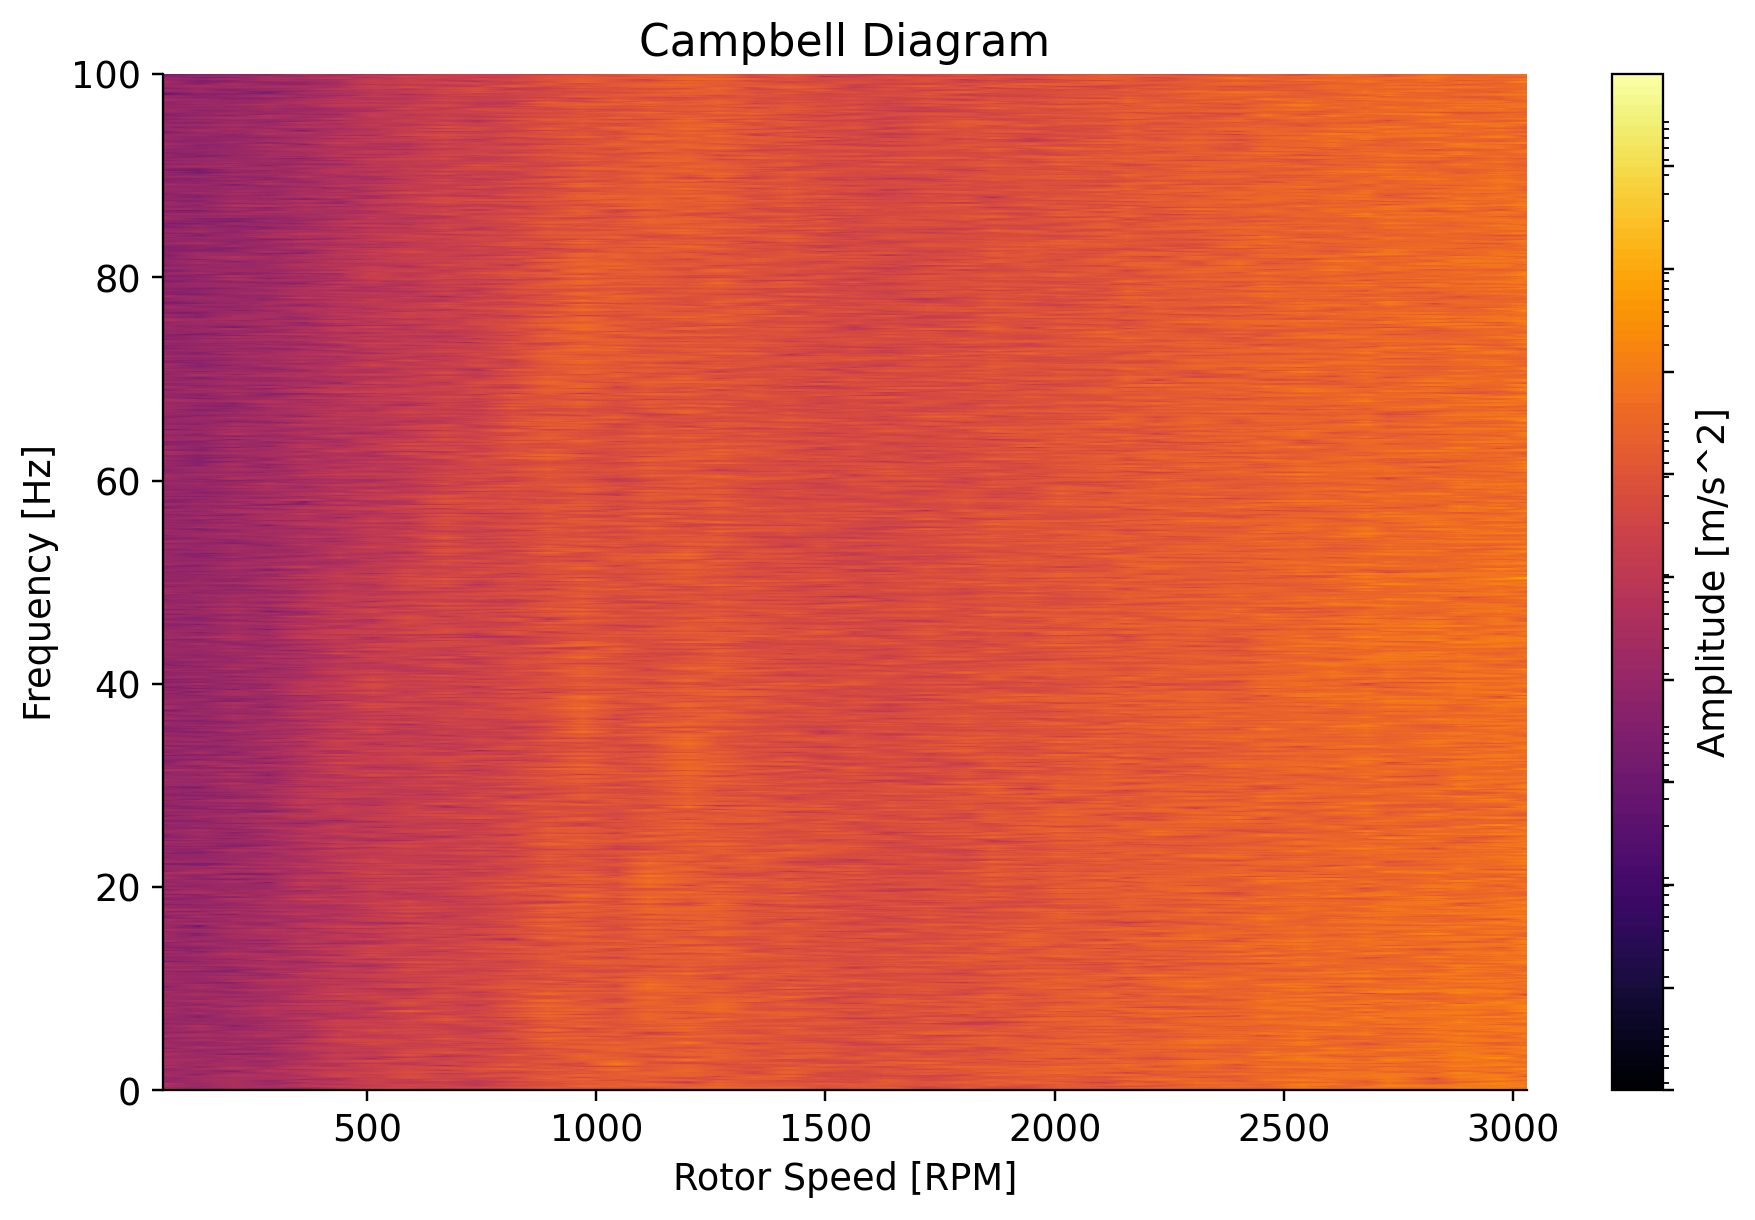

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm 
with h5py.File(file_path, 'r') as f:
    rpm_list = []
    for i in range(len(f.keys())):
        rpm_list.append(f[str(i)]["RawData"]['1ee823b3-32d9-6d20-8261-106b0e021eed']["motor_rpm"][()])


fig, ax = plt.subplots(figsize=(10, 6))

x, y = np.meshgrid(rpm_list, fft_frequencies)
z = np.transpose(all_fft_amplitudes)


contour_levels = np.logspace(np.log10(np.min(z)), np.log10(np.max(z)), 100)


contourf = ax.contourf(x, y, z, cmap='inferno', levels=contour_levels, norm=LogNorm())

ax.set_xlabel('Rotor Speed [RPM]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title('Campbell Diagram')
ax.set_ylim(0, 100)

cbar = plt.colorbar(contourf, ax=ax, orientation='vertical')
cbar.set_label('Amplitude [m/s^2]')

plt.show()

## Dritter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [87]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = 'data_20240109_104244_lavalrotor_01_04.h5'  # name of the H5-file



measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)



# Define the file path
file_path = 'measurement_data/data_20240109_104244_lavalrotor_01_04/data_20240109_104244_lavalrotor_01_04.h5'


def find_dataset_path(hdf5_group, target_dataset):
    for key in hdf5_group.keys():
       
        if isinstance(hdf5_group[key], h5py.Group):
            path_in_group = find_dataset_path(hdf5_group[key], target_dataset)
            if path_in_group:
                return key + '/' + path_in_group
     
        elif key == target_dataset:
            return key

all_accel_x=[]
all_accel_y=[]
all_accel_z=[]
all_timestamp=[]


with h5py.File(file_path, 'r') as hdf5_file:
    

    sorted_keys = sorted(map(int, hdf5_file.keys()))
    rpmlist = set()
   
    for key in sorted_keys:
        print(f"\nKey: {key}")
        
       
        group = hdf5_file[str(key)]
        
     
        target_datasets = ['timestamp', 'acceleration_x', 'acceleration_y', 'acceleration_z','motor_rpm']
        
     
        dataset_paths = {dataset: find_dataset_path(group, dataset) for dataset in target_datasets}
        
    
        if all(dataset_paths.values()):
   
            timestamp_data = np.array(group[dataset_paths['timestamp']])
            accel_x_data = np.array(group[dataset_paths['acceleration_x']])
            accel_y_data = np.array(group[dataset_paths['acceleration_y']])
            accel_z_data = np.array(group[dataset_paths['acceleration_z']])
            motor_rpm_data = np.array(group[dataset_paths['motor_rpm']])
            
            if motor_rpm_data.size == 1:
                rpmlist.add(motor_rpm_data.item()) 
            else:
                rpmlist.update(set(motor_rpm_data.tolist()))  
            
            all_accel_x.append(accel_x_data.tolist())
            all_accel_y.append(accel_y_data.tolist())
            all_accel_z.append(accel_z_data.tolist())
            all_timestamp.append(timestamp_data.tolist())
        
        
            print(f"Timestamp: {timestamp_data}")
            print(f"Acceleration X: {accel_x_data}")
            print(f"Acceleration Y: {accel_y_data}")
            print(f"Acceleration Z: {accel_z_data}")
            print(f"Motor RPM: {motor_rpm_data}")
        else:
            print("Some datasets not found in the specified path.")

            
print("rpmlist", sorted(rpmlist))


Key: 0
Timestamp: [1.09434128e-03 4.56881523e-03 7.85160065e-03 ... 9.98774004e+00
 9.99305487e+00 9.99803400e+00]
Acceleration X: [0.2353596 0.2353596 0.3530394 ... 0.2353596 0.196133  0.3138128]
Acceleration Y: [0.2745862 0.196133  0.2745862 ... 0.1569064 0.2353596 0.1176798]
Acceleration Z: [12.0033396 12.1994726 12.0033396 ... 11.9248864 12.0033396 11.964113 ]
Motor RPM: 94

Key: 1
Timestamp: [1.07908249e-03 3.93843651e-03 6.66427612e-03 ... 9.99391413e+00
 9.99687886e+00 1.00000145e+01]
Acceleration X: [0.2745862 0.1176798 0.2353596 ... 0.2745862 0.196133  0.588399 ]
Acceleration Y: [0.3530394 0.196133  0.2353596 ... 0.3530394 0.3138128 0.2745862]
Acceleration Z: [12.0817928 11.8856598 11.8856598 ... 12.0817928 11.8464332 11.8072066]
Motor RPM: 206

Key: 2
Timestamp: [1.07955933e-03 3.92818451e-03 6.65378571e-03 ... 9.99417019e+00
 9.99765849e+00 1.00011132e+01]
Acceleration X: [0.392266  0.2353596 0.1569064 ... 0.9414384 0.392266  1.1375714]
Acceleration Y: [0.1176798 0.5491724 

#### 2. Verarbeitung der Messdaten

In [88]:
importlib.reload(m_postprocessing)  # reload functions

with h5py.File(file_path, 'r') as hdf5_file:

    sorted_keys = sorted(map(int, hdf5_file.keys()))
    all_accel_magnitudes = []


    for key in sorted_keys:
        group = hdf5_file[str(key)]

        try:
  
            raw_data_group = group['RawData']


            accel_x_data = np.array(raw_data_group['1ee823d6-3d20-6332-83f5-6876b760dcf3']['acceleration_x'])
            accel_y_data = np.array(raw_data_group['1ee823d6-3d20-6332-83f5-6876b760dcf3']['acceleration_y'])
            accel_z_data = np.array(raw_data_group['1ee823d6-3d20-6332-83f5-6876b760dcf3']['acceleration_z'])

            accel_magnitude = m_postprocessing.get_vec_accel(accel_x_data, accel_y_data, accel_z_data)

            all_accel_magnitudes.append(accel_magnitude)
        except KeyError as e:
            print(f"Error accessing group {key}: {e}")
            
all_interpolated_values = []

for i, accel_magnitude in enumerate(all_accel_magnitudes):

    time_data = timestamp_data
    target_size = np.size(accel_magnitude)

    interpolated_time_data = m_postprocessing.interpolation(np.arange(len(time_data)), time_data, np.arange(target_size))

    try:
        interpolated_values = m_postprocessing.interpolation(interpolated_time_data, accel_magnitude, interpolation_points)
        all_interpolated_values.append(interpolated_values)

    except Exception as e:
        print(f"Error during interpolation for Group {i + 1}: {e}")

        
all_fft_amplitudes = []
all_fft_frequencies = []

for i, interpolated_values in enumerate(all_interpolated_values):

    fft_amplitudes, fft_frequencies = m_postprocessing.my_fft_scaled(interpolated_values, interpolation_points)

    all_fft_amplitudes.append(fft_amplitudes)
    all_fft_frequencies.append(fft_frequencies)



#### 3. Darstellung mittels Campbell-Diagramm

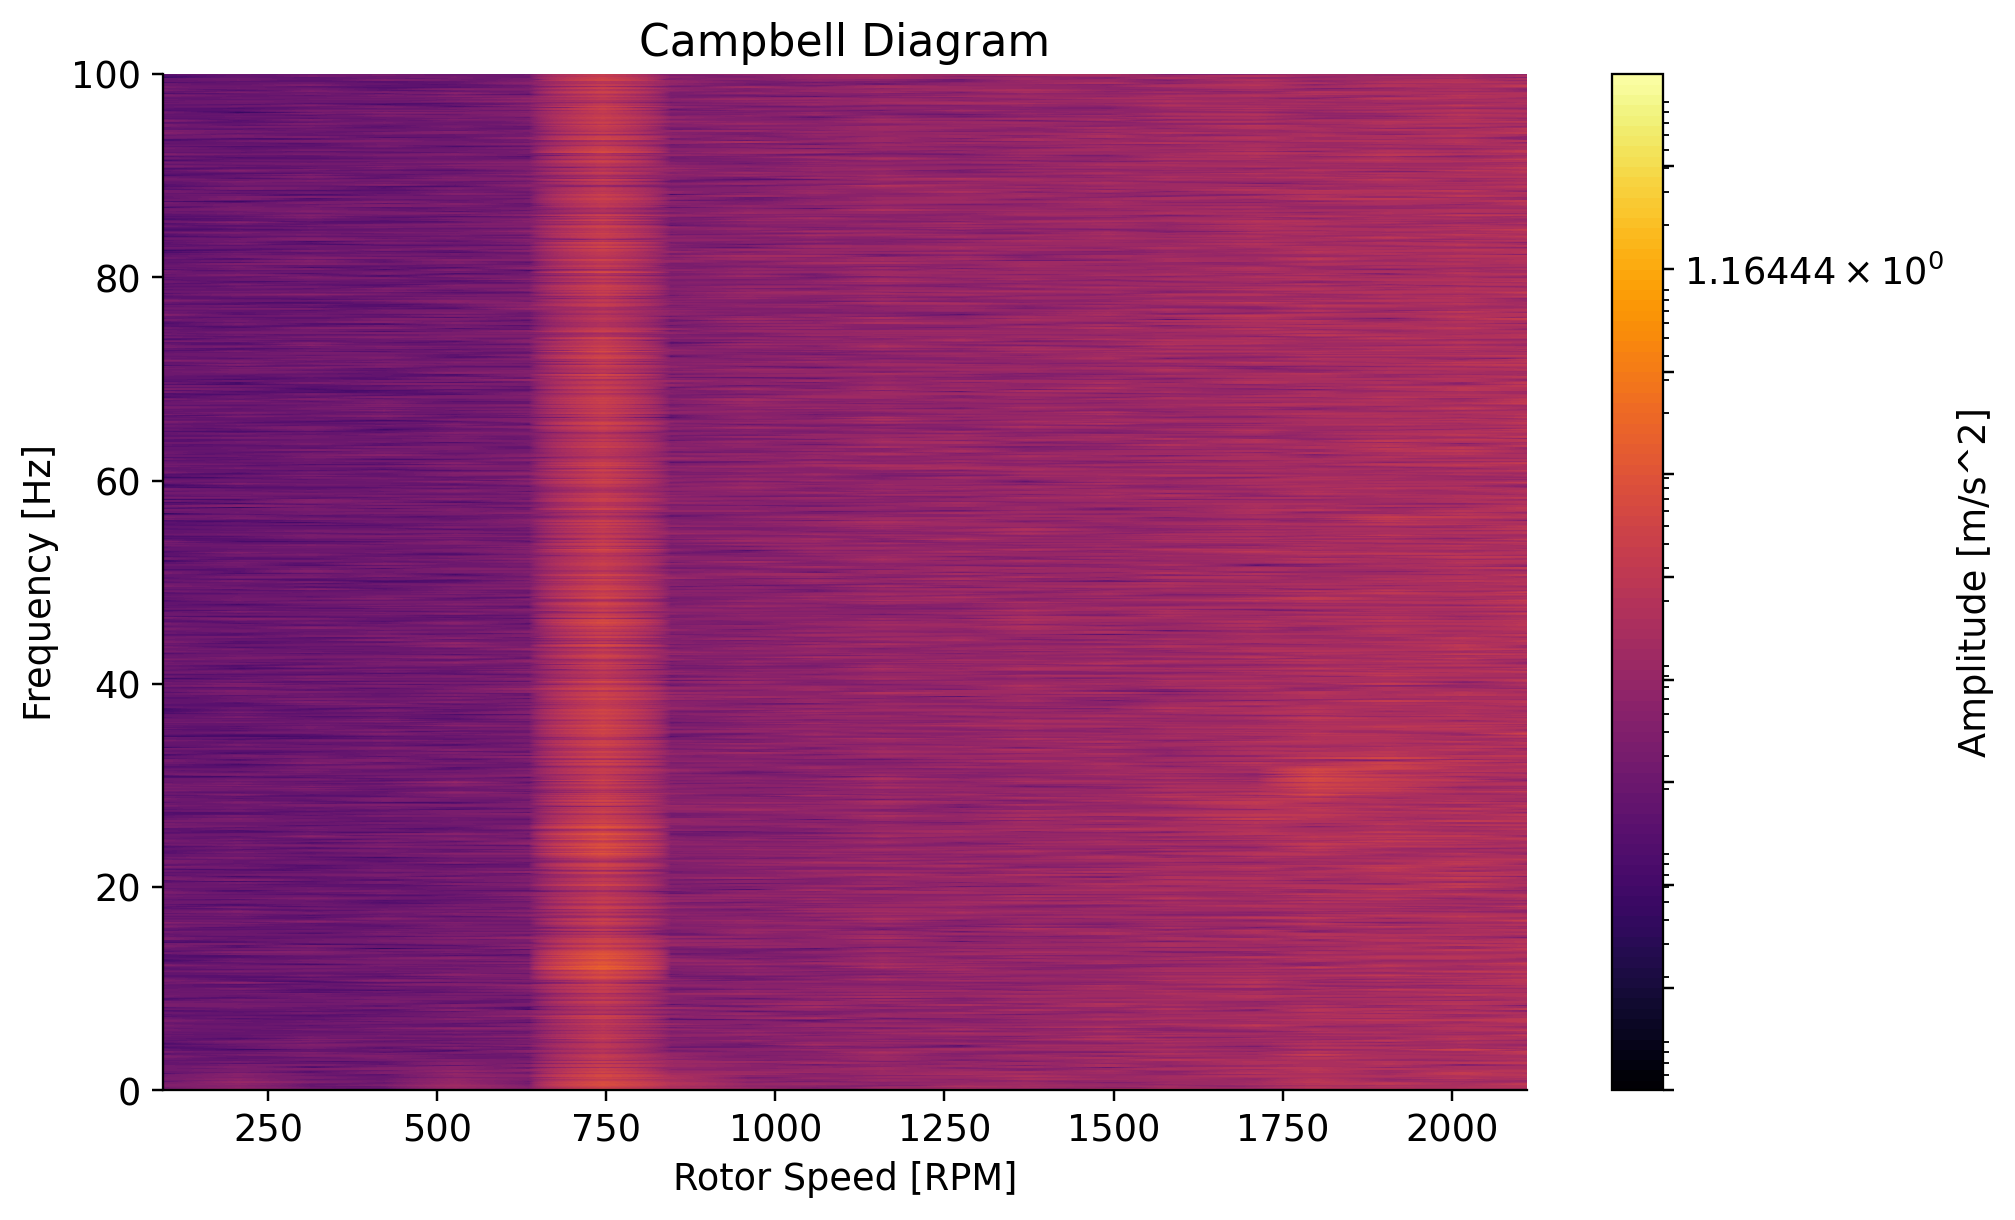

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm 
with h5py.File(file_path, 'r') as f:
    rpm_list = []
    for i in range(len(f.keys())):
        rpm_list.append(f[str(i)]["RawData"]['1ee823b6-50dc-6670-aea5-35f6dd717e83']["motor_rpm"][()])


fig, ax = plt.subplots(figsize=(10, 6))

x, y = np.meshgrid(rpm_list, fft_frequencies)
z = np.transpose(all_fft_amplitudes)


contour_levels = np.logspace(np.log10(np.min(z)), np.log10(np.max(z)), 100)


contourf = ax.contourf(x, y, z, cmap='inferno', levels=contour_levels, norm=LogNorm())

ax.set_xlabel('Rotor Speed [RPM]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title('Campbell Diagram')
ax.set_ylim(0, 100)

cbar = plt.colorbar(contourf, ax=ax, orientation='vertical')
cbar.set_label('Amplitude [m/s^2]')

plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

1. Wie unterscheiden sich die Prüfstände hinsichtlich ihrer rotordynamischen Stabilität?
-Die erste Prüfstand besteht aus einer einzelnen Scheibe mit einem Gewicht von 950 g, einer Dicke von 15 mm und einem Durchmesser von 99mm. Sie ist auf einer Welle mit einer Länge von 0,75 mm und einem Durchmesser von 10mm montiert.
-Die zweite Prüfstand umfasst zwei Scheiben, jede mit einem Gewicht von 500 g, einer Dicke von 7 mm und einem Durchmesser von 99 mm. Zusätzlich gibt es zwei Abstützlager mit einem Durchmesser von jeweils 500 mm. Die Abstände dieser Lage zum Motorlager betragen 250 mm und 500 mm.
-Die dritte Prüfstand ist eine Scheibe mit einem Geiwicht von 1000 g, einer Dicke von 15 mm und einem Durchmesser von 99 mm. Es gibt ein Abstützlager, das sich in einem Abstand von 450 mm zum Motorlager befindet.

2. Was sind die kritischen Bereiche der Rotoren?
-Auf dem ersten Prüfstand sind kritische Bereiche bei Rotordrehzahlen von 1000-1500 rpm und ungefähr 2500 rpm zu beobachten. Die Frequenz liegt im Bereich von 20-40 Hz.
-Beim zweiten Prüfstand zeigen sich kritische Bereiche bei Rotordrehzahlen von 700-1300 rpm, und dies betrifft den gesamten Frequenzbereich. 
-Im drifften Prüfstand sind kritische Bereiche bei Rotordrehzahlen von 700-800 rpm für den gesamten Frequenzbereich zu beobachten. Zusätzlich gibt es einen kritischen Bereich bei 1750-1900 rpm mit einem Frequenzbereich von etwa 30 Hz.

3. Kann die Selbstzentrierung der Rotoren in den Messdaten gesehen werden?
-Selbstzentrierung konnte im ersten Prüfstand beobachtet werden. Eine Unwucht war relativ gleichmäßig über den Rotor verteilt. Im Gegensatz zum ersten Prüfstand befinden sich die kritischen Bereiche des zweiten und des dritten Prüfstands in einem engen Bereich. Das kännte bedeuten, dass keine Selbstzentrierung vorhanden ist.

### Vergleich der gemessenen mit der analytisch berechneten Amplitude
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

In [90]:
import math


E = 210000  # Elastizitätsmodul des Materials (N/mm^2)
I = (math.pi/4)*((99/2)**4)# Flächenträgheitsmoment der Scheibe (mm^4)
m = 950  # Masse der Scheibe (g)
l = 750  # Länge der Rotorwelle (mm)

n_krit = 10*(2 / math.pi) * math.sqrt((3 * E * I) / (m * l**3)) #in Hz



# Calculate n_krit in rpm
Kritische_Drehzahl = n_krit * 60



print(f"kritische Drehzahl in rpm ist: {Kritische_Drehzahl}")


kritische Drehzahl in rpm ist: 1039.9280411417765


Es wurde festgestellt, dass die gemessene kritische Drehyahl etwa 1300 rpm beträgt, während die analytisch berechnete kritische Drehzahl bei 1039 rpm liegt. Es gibt zwar eine leichte Abweichung, aber sie liegt immer noch im Bereich der kritischen Drehzahlen im Campbell Diagramm.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Das Campbell Diagramm zeigt verschiedene Instabilitätszonen unter verschiedenen Bedingungen auf. Es zeigt auch, welche Entwicklungen durch die Anazlyse des Diagramms erforderlich sein könnten. Ich denke, es ist wichtig, das Campbell-Diagramm zu nutzen, wenn wir Rotormaschinen optimieren möchten und beobachten wollen, welche Probleme auftreten könnten.

Persönlich finde ich, dass diese Aufgabe eng mit dem verbunden ist, was wir als Ingenieure in unseren zukünftigen Berufen tun werden. Ich konnte ein grunlegendes Verständnis dafür entwickeln, wie man Campbell-Diagramm verwendet und analysiert. Außerdem denke ich, es wäre besser gewesen, wenn wir in anderen Modulen zuvor etwas über das Diagramm gelernt hätten, bevor wir diese Aufgabe angegangen sind.